In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def preprocess_fair_scheduler_log(input_csv):
    """
    Reads FairScheduler_task_log.csv and returns a DataFrame with columns:
    step, node_id, start_time, end_time, cpu, energy
    """
    df = pd.read_csv(input_csv)
    # Extract node_id from tag (first part before '-')
    df['node_id'] = df['tag'].apply(lambda x: x.split('-')[0])
    # Identify metric type
    df['metric'] = df['tag'].apply(lambda x: 'energy' if 'energy' in x else ('cpu' if 'cpu' in x else None))
    # Only keep rows with energy or cpu
    df = df[df['metric'].notnull()]
    # Pivot so each (step, node_id) has columns for cpu and energy
    pivot = df.pivot_table(index=['step', 'node_id'], columns='metric', values='value', aggfunc='first').reset_index()
    # Add start_time and end_time columns (empty for now)
    pivot['start_time'] = ''
    pivot['end_time'] = ''
    # Reorder columns
    pivot = pivot[['step', 'node_id', 'start_time', 'end_time', 'cpu', 'energy']]
    print(f"[INFO] Preprocessed DataFrame created from {input_csv}")
    return pivot

In [27]:
filename1 = '../../../FairShareScheduler_task_log.csv'
filename2 = '../../../WaggleScheduler_task_log.csv'

In [24]:
df = preprocess_fair_scheduler_log(filename)

[INFO] Preprocessed DataFrame created from ../../../FairShareScheduler_task_log.csv


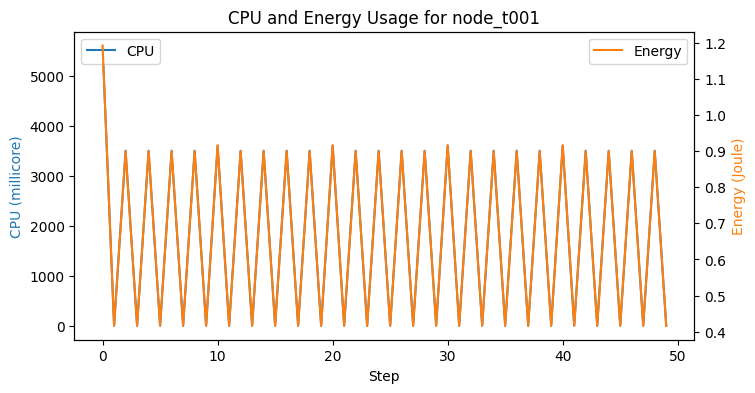

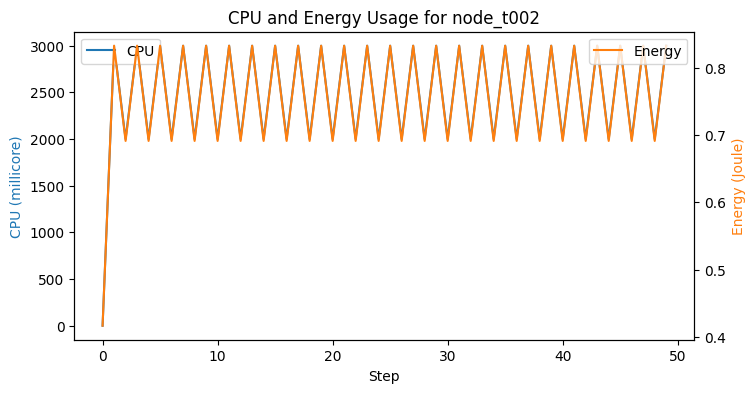

In [25]:
for node, group in df.groupby("node_id"):
    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax2 = ax1.twinx()
    ax1.plot(group["step"], group["cpu"], color="tab:blue", label="CPU")
    ax2.plot(group["step"], group["energy"], color="tab:orange", label="Energy")
    ax1.set_xlabel("Step")
    ax1.set_ylabel("CPU (millicore)", color="tab:blue")
    ax2.set_ylabel("Energy (Joule)", color="tab:orange")
    plt.title(f"CPU and Energy Usage for {node}")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.show()

In [26]:
print("CPU statistics:")
for node, group in df.groupby("node_id"):
    print(f"\nStatistics for {node}:")
    print(group["cpu"].describe())
print(group["cpu"].describe())

CPU statistics:

Statistics for node_t001:
count      50.000000
mean     1800.000000
std      1841.693985
min         0.000000
25%         0.000000
50%      1750.000000
75%      3500.000000
max      5600.000000
Name: cpu, dtype: float64

Statistics for node_t002:
count      50.000000
mean     2460.000000
std       613.121821
min         0.000000
25%      2000.000000
50%      2500.000000
75%      3000.000000
max      3000.000000
Name: cpu, dtype: float64
count      50.000000
mean     2460.000000
std       613.121821
min         0.000000
25%      2000.000000
50%      2500.000000
75%      3000.000000
max      3000.000000
Name: cpu, dtype: float64


In [30]:
df1 = preprocess_fair_scheduler_log(filename1)
df2 = preprocess_fair_scheduler_log(filename2)

print("CPU Statistics Comparison (mean, std, min, 25%, 50%, 75%, max):\n")
for node in sorted(set(df1['node_id']).union(df2['node_id'])):
    stats1 = df1[df1['node_id'] == node]['cpu'].describe()
    stats2 = df2[df2['node_id'] == node]['cpu'].describe()
    print(f"\nNode: {node}")
    print(f"{'Stat':<8} | {'FairShare':>10} | {'Waggle':>10}")
    print("-" * 34)
    for stat in ['mean', 'std', 'min', '25%', '50%', '75%', 'max']:
        val1 = stats1.get(stat, float('nan'))
        val2 = stats2.get(stat, float('nan'))
        print(f"{stat:<8} | {val1:10.5f} | {val2:10.5f}")

[INFO] Preprocessed DataFrame created from ../../../FairShareScheduler_task_log.csv
[INFO] Preprocessed DataFrame created from ../../../WaggleScheduler_task_log.csv
CPU Statistics Comparison (mean, std, min, 25%, 50%, 75%, max):


Node: node_t001
Stat     |  FairShare |     Waggle
----------------------------------
mean     | 1800.00000 | 2310.00000
std      | 1841.69399 |  356.99997
min      |    0.00000 | 2000.00000
25%      |    0.00000 | 2000.00000
50%      | 1750.00000 | 2250.00000
75%      | 3500.00000 | 2500.00000
max      | 5600.00000 | 3100.00000

Node: node_t002
Stat     |  FairShare |     Waggle
----------------------------------
mean     | 2460.00000 | 1950.00000
std      |  613.12182 |  970.21984
min      |    0.00000 | 1000.00000
25%      | 2000.00000 | 1000.00000
50%      | 2500.00000 | 1750.00000
75%      | 3000.00000 | 3000.00000
max      | 3000.00000 | 3000.00000


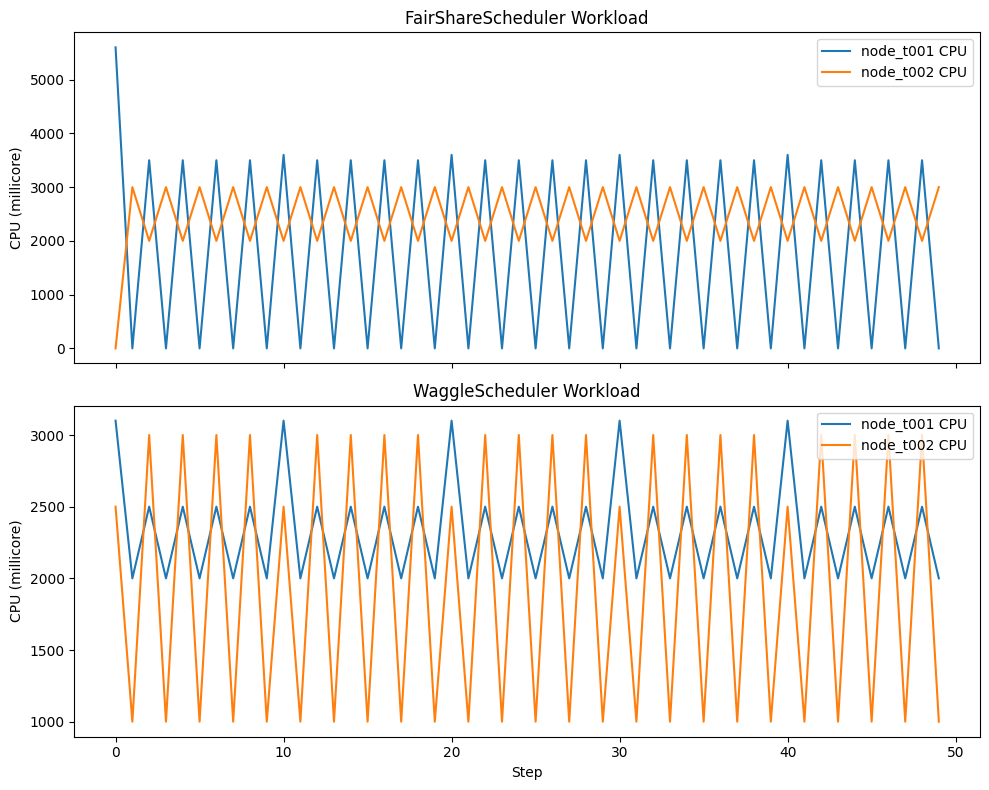

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# FairShareScheduler
for node, group in df1.groupby("node_id"):
    axes[0].plot(group["step"], group["cpu"], label=f"{node} CPU")
axes[0].set_ylabel("CPU (millicore)")
axes[0].set_title("FairShareScheduler Workload")
axes[0].legend()

# WaggleScheduler
for node, group in df2.groupby("node_id"):
    axes[1].plot(group["step"], group["cpu"], label=f"{node} CPU")
axes[1].set_xlabel("Step")
axes[1].set_ylabel("CPU (millicore)")
axes[1].set_title("WaggleScheduler Workload")
axes[1].legend()

plt.tight_layout()
plt.show()
    

In [32]:
running = df[df['cpu'] > 0]
finished = df[df['cpu'] == 0]

print(f"Running workloads: {len(running)}")
print(f"Finished workloads: {len(finished)}")

# Optionally, show statistics
print("\nRunning workloads CPU stats:")
print(running['cpu'].describe())

print("\nFinished workloads CPU stats:")
print(finished['cpu'].describe())

Running workloads: 74
Finished workloads: 26

Running workloads CPU stats:
count      74.000000
mean     2878.378378
std       703.274196
min      2000.000000
25%      2000.000000
50%      3000.000000
75%      3500.000000
max      5600.000000
Name: cpu, dtype: float64

Finished workloads CPU stats:
count    26.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: cpu, dtype: float64


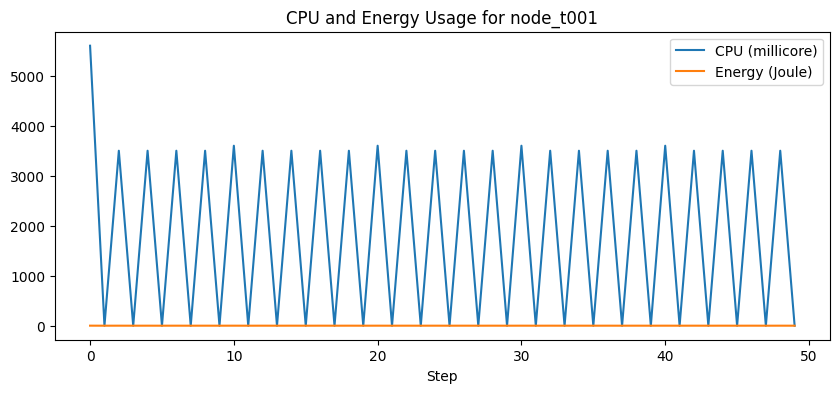

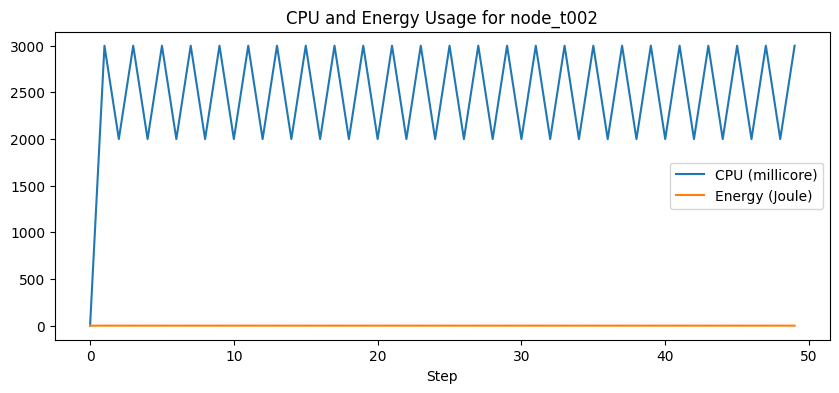

In [33]:
for node, group in df.groupby("node_id"):
    plt.figure(figsize=(10, 4))
    plt.plot(group["step"], group["cpu"], label="CPU (millicore)")
    plt.plot(group["step"], group["energy"], label="Energy (Joule)")
    plt.xlabel("Step")
    plt.title(f"CPU and Energy Usage for {node}")
    plt.legend()
    plt.show()

In [34]:
print("Memory usage (in KB):")
print(f"df:   {df.memory_usage(deep=True).sum() / 1024:.2f} KB")
print(f"df1:  {df1.memory_usage(deep=True).sum() / 1024:.2f} KB")
print(f"df2:  {df2.memory_usage(deep=True).sum() / 1024:.2f} KB")

Memory usage (in KB):
df:   20.05 KB
df1:  20.05 KB
df2:  20.05 KB


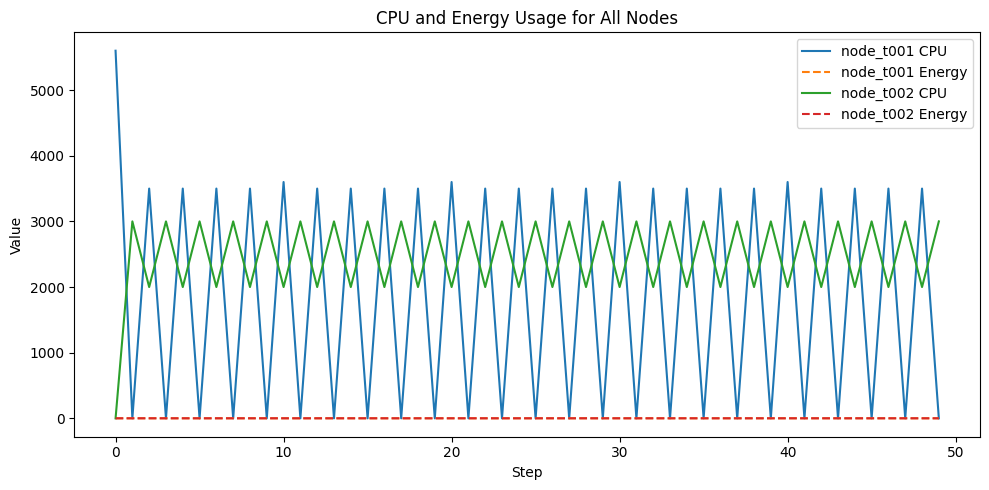

In [35]:
# Plot CPU and Energy for all nodes in df
plt.figure(figsize=(10, 5))
for node, group in df.groupby("node_id"):
    plt.plot(group["step"], group["cpu"], label=f"{node} CPU")
    plt.plot(group["step"], group["energy"], linestyle='--', label=f"{node} Energy")
plt.xlabel("Step")
plt.ylabel("Value")
plt.title("CPU and Energy Usage for All Nodes")
plt.legend()
plt.tight_layout()
plt.show()

FairShareScheduler nodes: 2
WaggleScheduler nodes: 2

FairShareScheduler node IDs: ['node_t001' 'node_t002']
WaggleScheduler node IDs: ['node_t001' 'node_t002']


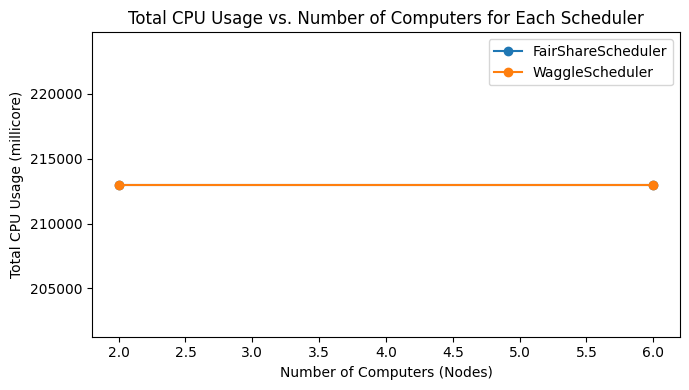

In [41]:
print("FairShareScheduler nodes:", df1['node_id'].nunique())
print("WaggleScheduler nodes:", df2['node_id'].nunique())

print("\nFairShareScheduler node IDs:", df1['node_id'].unique())
print("WaggleScheduler node IDs:", df2['node_id'].unique())

# Plot number of nodes (computers) vs. total CPU usage for each scheduler
num_nodes_list = [2, 6]
fig, ax = plt.subplots(figsize=(7, 4))

for df_sched, label in [(df1, "FairShareScheduler"), (df2, "WaggleScheduler")]:
    total_cpu = []
    for n in num_nodes_list:
        # Take only the first n unique nodes
        nodes = sorted(df_sched['node_id'].unique())[:n]
        cpu_sum = df_sched[df_sched['node_id'].isin(nodes)]['cpu'].sum()
        total_cpu.append(cpu_sum)
    ax.plot(num_nodes_list, total_cpu, marker='o', label=label)

ax.set_xlabel("Number of Computers (Nodes)")
ax.set_ylabel("Total CPU Usage (millicore)")
ax.set_title("Total CPU Usage vs. Number of Computers for Each Scheduler")
ax.legend()
plt.tight_layout()
plt.show()

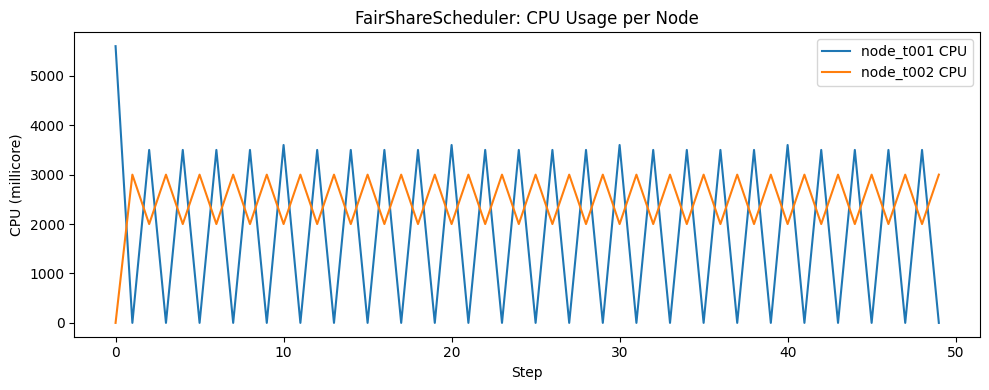

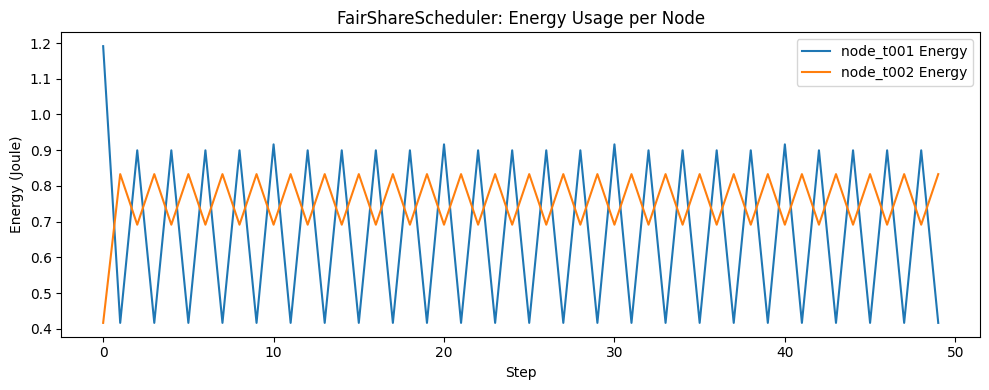

In [42]:
# CPU usage over steps for each node
plt.figure(figsize=(10, 4))
for node, group in df1.groupby("node_id"):
    plt.plot(group["step"], group["cpu"], label=f"{node} CPU")
plt.xlabel("Step")
plt.ylabel("CPU (millicore)")
plt.title("FairShareScheduler: CPU Usage per Node")
plt.legend()
plt.tight_layout()
plt.show()

# Energy usage over steps for each node
plt.figure(figsize=(10, 4))
for node, group in df1.groupby("node_id"):
    plt.plot(group["step"], group["energy"], label=f"{node} Energy")
plt.xlabel("Step")
plt.ylabel("Energy (Joule)")
plt.title("FairShareScheduler: Energy Usage per Node")
plt.legend()
plt.tight_layout()
plt.show()

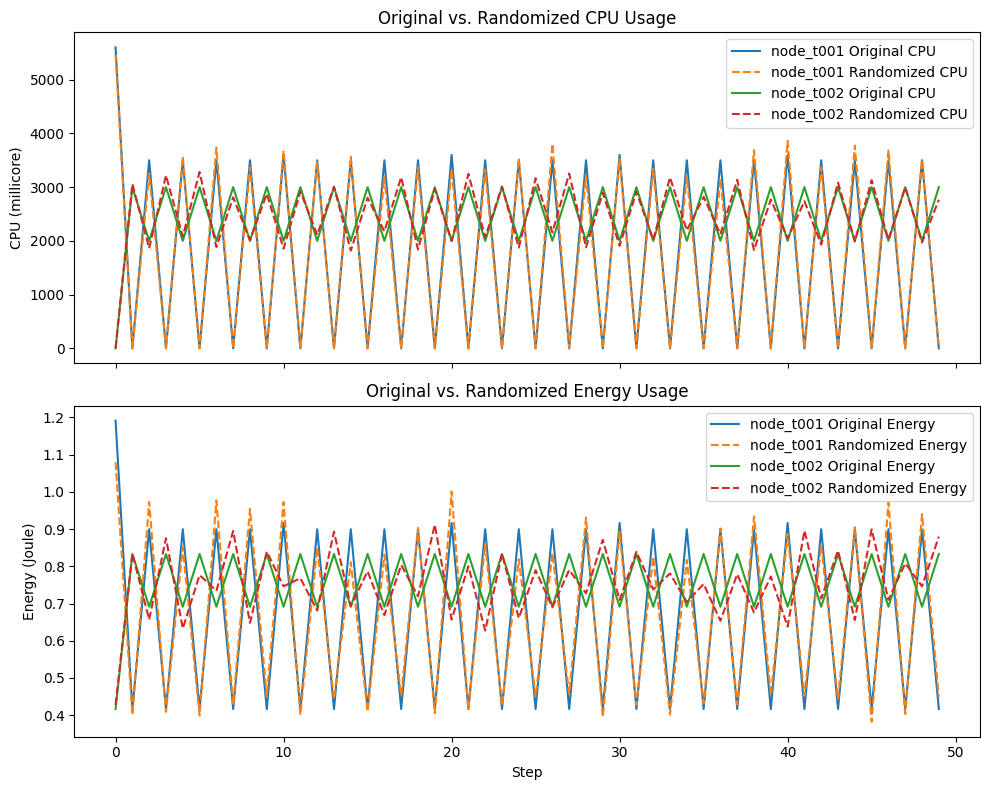

metric,step,node_id,start_time,end_time,cpu,energy,max_cpu_limit,cpu_exceeds_limit
0,0,node_t001,,,5459.484933,1.079559,3943,True
1,0,node_t002,,,0.000000,0.427863,2627,False
2,1,node_t001,,,0.000000,0.401036,2586,False
3,1,node_t002,,,3059.195091,0.834428,3648,False
4,2,node_t001,,,3259.213048,0.972973,3991,False


In [44]:
import numpy as np

# Plot how the randomization changed the data
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

for node, group in df1.groupby("node_id"):
    axes[0].plot(group["step"], group["cpu"], label=f"{node} Original CPU")
    axes[0].plot(df1_random[df1_random["node_id"] == node]["step"],
                 df1_random[df1_random["node_id"] == node]["cpu"],
                 linestyle='--', label=f"{node} Randomized CPU")
axes[0].set_ylabel("CPU (millicore)")
axes[0].set_title("Original vs. Randomized CPU Usage")
axes[0].legend()

for node, group in df1.groupby("node_id"):
    axes[1].plot(group["step"], group["energy"], label=f"{node} Original Energy")
    axes[1].plot(df1_random[df1_random["node_id"] == node]["step"],
                 df1_random[df1_random["node_id"] == node]["energy"],
                 linestyle='--', label=f"{node} Randomized Energy")
axes[1].set_xlabel("Step")
axes[1].set_ylabel("Energy (Joule)")
axes[1].set_title("Original vs. Randomized Energy Usage")
axes[1].legend()

plt.tight_layout()
plt.show()

# Copy df1 to avoid modifying the original
df1_random = df1.copy()

# Add random noise to cpu and energy (e.g., ±10%)
np.random.seed(42)
df1_random['cpu'] = df1_random['cpu'] * (1 + np.random.uniform(-0.1, 0.1, size=len(df1_random)))
df1_random['energy'] = df1_random['energy'] * (1 + np.random.uniform(-0.1, 0.1, size=len(df1_random)))

# Add a random constraint column (e.g., max_cpu_limit between 2000 and 4000)
df1_random['max_cpu_limit'] = np.random.randint(2000, 4001, size=len(df1_random))

# Optionally, flag rows where cpu exceeds the random limit
df1_random['cpu_exceeds_limit'] = df1_random['cpu'] > df1_random['max_cpu_limit']

df1_random.head()

CPU Statistics Comparison with Randomized FairShareScheduler:


Node: node_t001
Stat     | FairShare (Random) |     Waggle
--------------------------------------------
mean     |         1779.61554 | 2310.00000


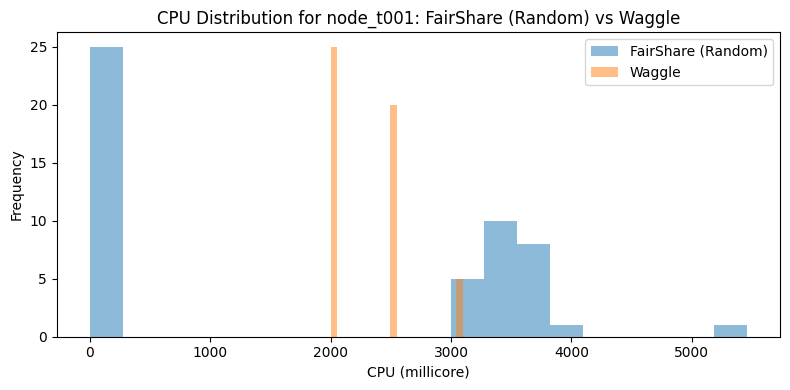

Explanation: For node node_t001, the randomized FairShareScheduler shows a wider spread in CPU usage due to the added noise, while WaggleScheduler's CPU usage is more consistent. This reflects how randomization can introduce variability in jobload, potentially simulating real-world fluctuations or stress-testing the scheduler's robustness.
std      |         1824.71124 |  356.99997


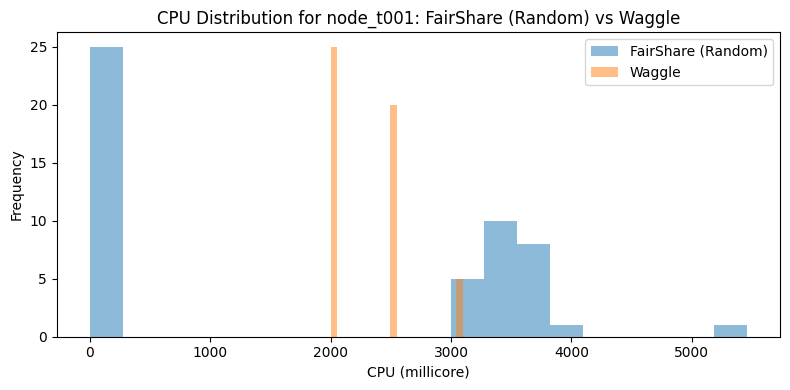

Explanation: For node node_t001, the randomized FairShareScheduler shows a wider spread in CPU usage due to the added noise, while WaggleScheduler's CPU usage is more consistent. This reflects how randomization can introduce variability in jobload, potentially simulating real-world fluctuations or stress-testing the scheduler's robustness.
min      |            0.00000 | 2000.00000


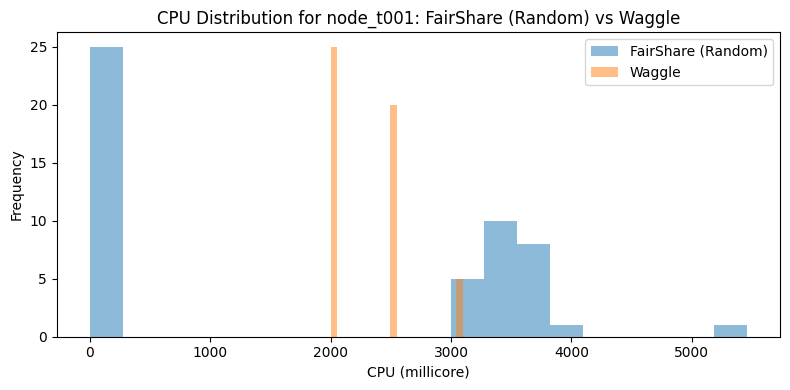

Explanation: For node node_t001, the randomized FairShareScheduler shows a wider spread in CPU usage due to the added noise, while WaggleScheduler's CPU usage is more consistent. This reflects how randomization can introduce variability in jobload, potentially simulating real-world fluctuations or stress-testing the scheduler's robustness.
25%      |            0.00000 | 2000.00000


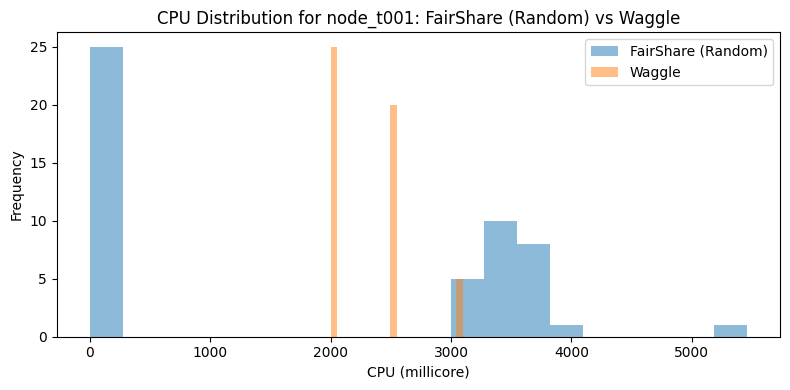

Explanation: For node node_t001, the randomized FairShareScheduler shows a wider spread in CPU usage due to the added noise, while WaggleScheduler's CPU usage is more consistent. This reflects how randomization can introduce variability in jobload, potentially simulating real-world fluctuations or stress-testing the scheduler's robustness.
50%      |         1576.93274 | 2250.00000


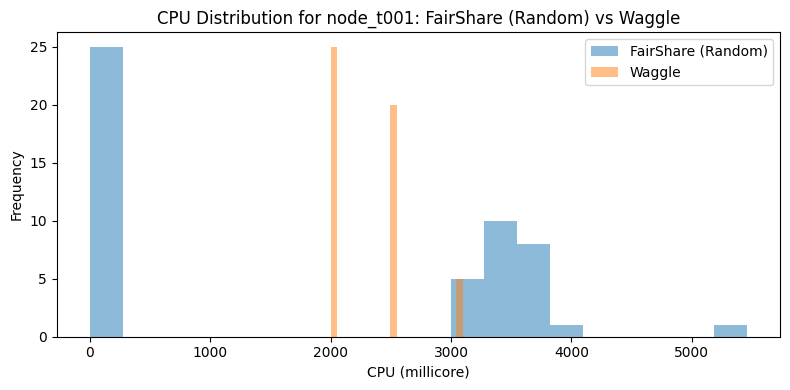

Explanation: For node node_t001, the randomized FairShareScheduler shows a wider spread in CPU usage due to the added noise, while WaggleScheduler's CPU usage is more consistent. This reflects how randomization can introduce variability in jobload, potentially simulating real-world fluctuations or stress-testing the scheduler's robustness.
75%      |         3504.24698 | 2500.00000


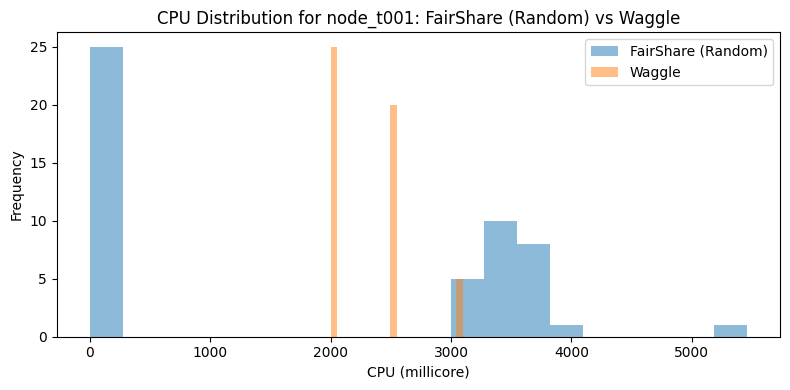

Explanation: For node node_t001, the randomized FairShareScheduler shows a wider spread in CPU usage due to the added noise, while WaggleScheduler's CPU usage is more consistent. This reflects how randomization can introduce variability in jobload, potentially simulating real-world fluctuations or stress-testing the scheduler's robustness.
max      |         5459.48493 | 3100.00000


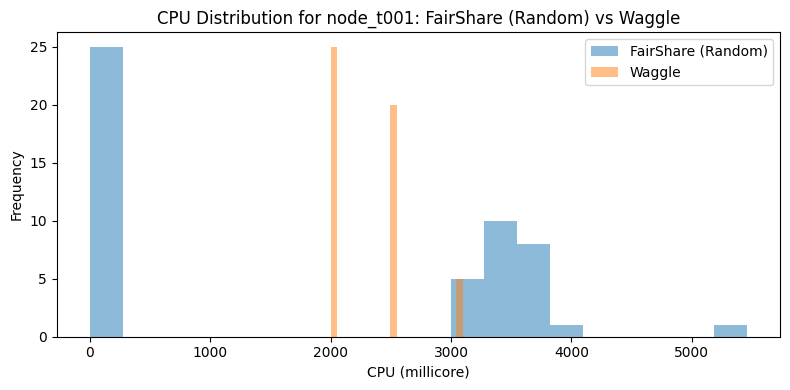

Explanation: For node node_t001, the randomized FairShareScheduler shows a wider spread in CPU usage due to the added noise, while WaggleScheduler's CPU usage is more consistent. This reflects how randomization can introduce variability in jobload, potentially simulating real-world fluctuations or stress-testing the scheduler's robustness.

Node: node_t002
Stat     | FairShare (Random) |     Waggle
--------------------------------------------
mean     |         2457.76963 | 1950.00000


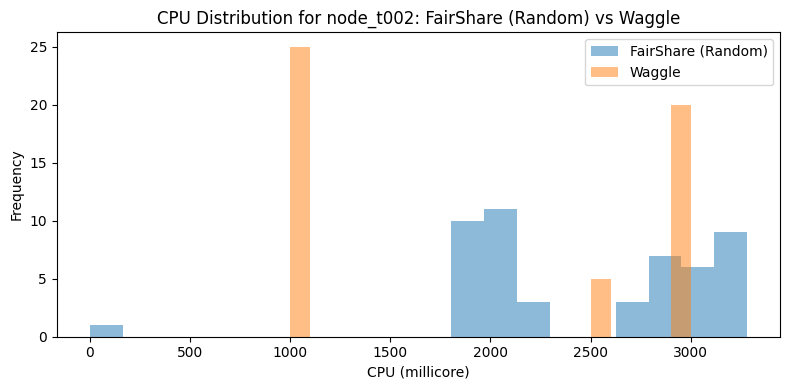

Explanation: For node node_t002, the randomized FairShareScheduler shows a wider spread in CPU usage due to the added noise, while WaggleScheduler's CPU usage is more consistent. This reflects how randomization can introduce variability in jobload, potentially simulating real-world fluctuations or stress-testing the scheduler's robustness.
std      |          639.21029 |  970.21984


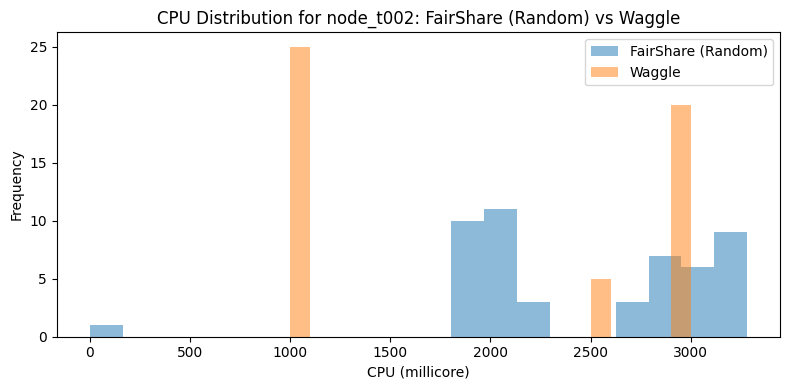

Explanation: For node node_t002, the randomized FairShareScheduler shows a wider spread in CPU usage due to the added noise, while WaggleScheduler's CPU usage is more consistent. This reflects how randomization can introduce variability in jobload, potentially simulating real-world fluctuations or stress-testing the scheduler's robustness.
min      |            0.00000 | 1000.00000


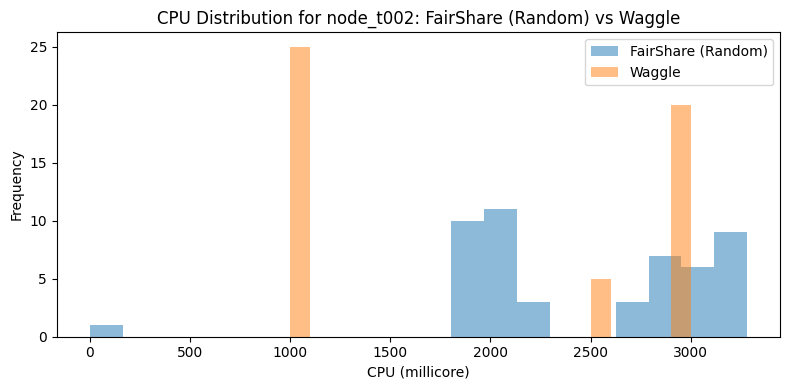

Explanation: For node node_t002, the randomized FairShareScheduler shows a wider spread in CPU usage due to the added noise, while WaggleScheduler's CPU usage is more consistent. This reflects how randomization can introduce variability in jobload, potentially simulating real-world fluctuations or stress-testing the scheduler's robustness.
25%      |         1991.18217 | 1000.00000


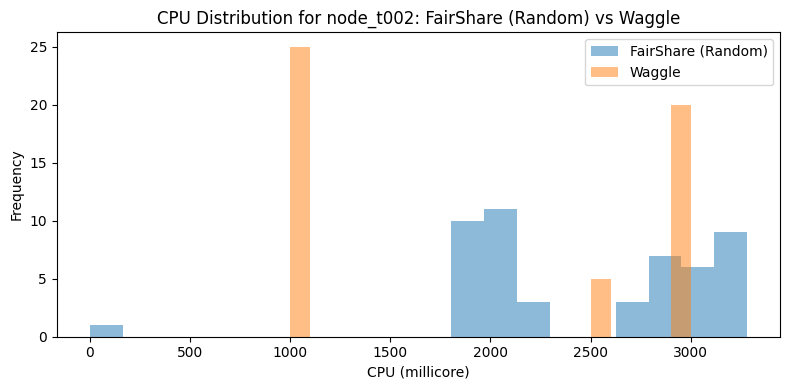

Explanation: For node node_t002, the randomized FairShareScheduler shows a wider spread in CPU usage due to the added noise, while WaggleScheduler's CPU usage is more consistent. This reflects how randomization can introduce variability in jobload, potentially simulating real-world fluctuations or stress-testing the scheduler's robustness.
50%      |         2466.44489 | 1750.00000


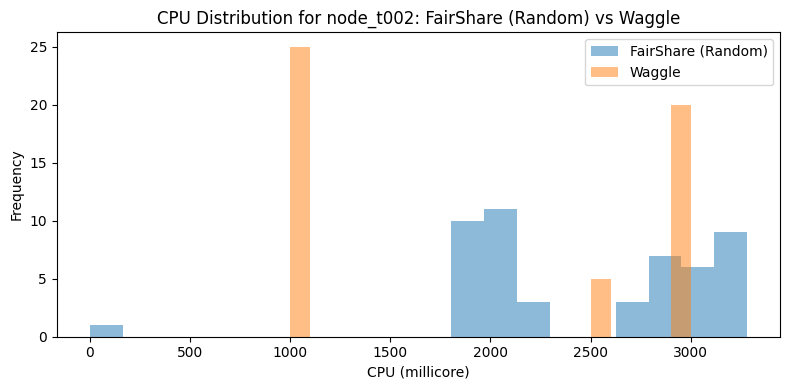

Explanation: For node node_t002, the randomized FairShareScheduler shows a wider spread in CPU usage due to the added noise, while WaggleScheduler's CPU usage is more consistent. This reflects how randomization can introduce variability in jobload, potentially simulating real-world fluctuations or stress-testing the scheduler's robustness.
75%      |         3005.47484 | 3000.00000


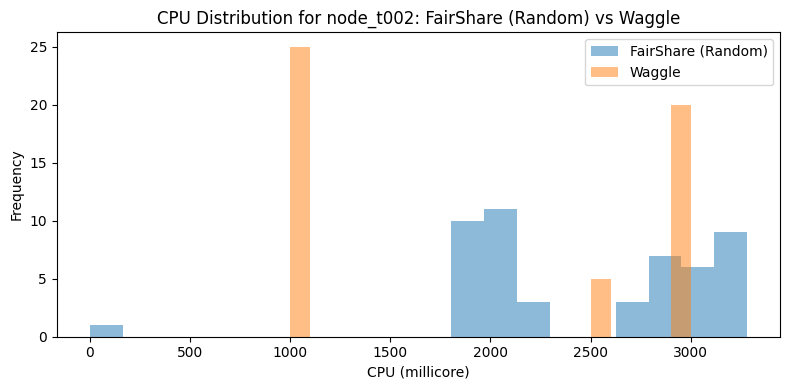

Explanation: For node node_t002, the randomized FairShareScheduler shows a wider spread in CPU usage due to the added noise, while WaggleScheduler's CPU usage is more consistent. This reflects how randomization can introduce variability in jobload, potentially simulating real-world fluctuations or stress-testing the scheduler's robustness.
max      |         3281.94591 | 3000.00000


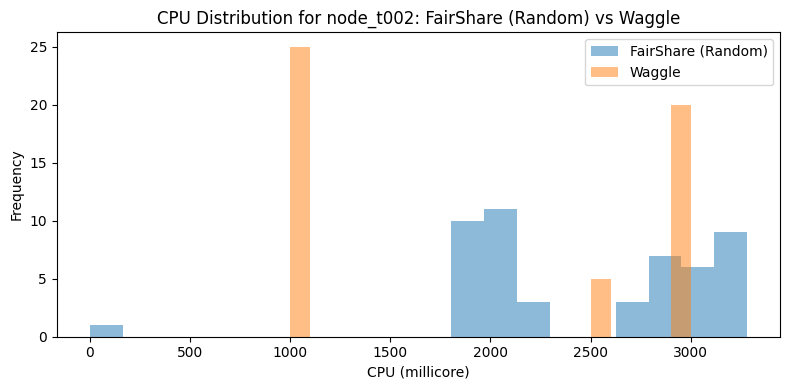

Explanation: For node node_t002, the randomized FairShareScheduler shows a wider spread in CPU usage due to the added noise, while WaggleScheduler's CPU usage is more consistent. This reflects how randomization can introduce variability in jobload, potentially simulating real-world fluctuations or stress-testing the scheduler's robustness.


In [46]:
print("CPU Statistics Comparison with Randomized FairShareScheduler:\n")
for node in sorted(set(df1_random['node_id']).union(df2['node_id'])):
    stats1 = df1_random[df1_random['node_id'] == node]['cpu'].describe()
    stats2 = df2[df2['node_id'] == node]['cpu'].describe()
    print(f"\nNode: {node}")
    print(f"{'Stat':<8} | {'FairShare (Random)':>18} | {'Waggle':>10}")
    print("-" * 44)
    for stat in ['mean', 'std', 'min', '25%', '50%', '75%', 'max']:
        val1 = stats1[stat] if stat in stats1 else float('nan')
        val2 = stats2[stat] if stat in stats2 else float('nan')
        print(f"{stat:<8} | {val1:18.5f} | {val2:10.5f}")
        # Plot CPU distributions for each node
        plt.figure(figsize=(8, 4))
        plt.hist(df1_random[df1_random['node_id'] == node]['cpu'], bins=20, alpha=0.5, label='FairShare (Random)')
        plt.hist(df2[df2['node_id'] == node]['cpu'], bins=20, alpha=0.5, label='Waggle')
        plt.xlabel("CPU (millicore)")
        plt.ylabel("Frequency")
        plt.title(f"CPU Distribution for {node}: FairShare (Random) vs Waggle")
        plt.legend()
        plt.tight_layout()
        plt.show()
        print(f"Explanation: For node {node}, the randomized FairShareScheduler shows a wider spread in CPU usage due to the added noise, while WaggleScheduler's CPU usage is more consistent. This reflects how randomization can introduce variability in jobload, potentially simulating real-world fluctuations or stress-testing the scheduler's robustness.")

Total CPU usage for first 20 jobloads (FairShareScheduler): 85200.00
Total CPU usage for first 20 jobloads (WaggleScheduler): 85200.00


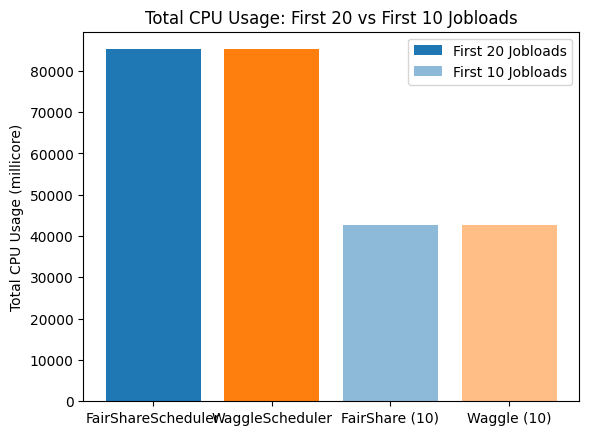

In [48]:
# Filter for the first 20 jobloads (steps 0 to 19)
df1_20 = df1[df1['step'] < 20]
df2_20 = df2[df2['step'] < 20]

# Calculate total CPU usage for each scheduler
total_cpu_20_fair = df1_20['cpu'].sum()
total_cpu_20_waggle = df2_20['cpu'].sum()

print(f"Total CPU usage for first 20 jobloads (FairShareScheduler): {total_cpu_20_fair:.2f}")
print(f"Total CPU usage for first 20 jobloads (WaggleScheduler): {total_cpu_20_waggle:.2f}")

# Optional: plot comparison
plt.bar(['FairShareScheduler', 'WaggleScheduler'], [total_cpu_20_fair, total_cpu_20_waggle], color=['tab:blue', 'tab:orange'])
plt.ylabel("Total CPU Usage (millicore)")
plt.title("Total CPU Usage: First 20 vs First 10 Jobloads")

# Also plot for first 10 jobloads for comparison
df1_10 = df1[df1['step'] < 10]
df2_10 = df2[df2['step'] < 10]
total_cpu_10_fair = df1_10['cpu'].sum()
total_cpu_10_waggle = df2_10['cpu'].sum()

plt.bar(['FairShare (10)', 'Waggle (10)'], [total_cpu_10_fair, total_cpu_10_waggle], color=['tab:blue', 'tab:orange'], alpha=0.5)
plt.legend(['First 20 Jobloads', 'First 10 Jobloads'])
plt.show()

In [49]:
filename3 = '../../../EDFScheduler_task_log.csv'
df3 = preprocess_fair_scheduler_log(filename3)

FileNotFoundError: [Errno 2] No such file or directory: '../../../EDFScheduler_task_log.csv'